# Object Detection on Pascal VOC Dataset 

## Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
# for pretty printed debugging
from IPython.core.debugger import set_trace

## Data

### create a dictionary of training annotations: {image_id: [ ([bb coordinates], cat_id)]}

In [4]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/tmp')]

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open())

In [15]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
imgs,annos,cats = trn_j['images'],trn_j['annotations'],trn_j['categories']

In [8]:
cats = {o['id']: o['name'] for o in cats}
trn_fns = {o['id']: o['file_name'] for o in imgs}
trn_ids = [o['id'] for o in imgs]

In [12]:
# VOC: left, top, right, bottom
# BB:  top, left, height, width
def hw_bb(arr): return np.array([arr[1], arr[0], arr[3]+arr[1]-1, arr[2]+arr[0]-1])
def bb_hw(arr): return np.array([arr[1], arr[0], arr[3]-arr[1]+1, arr[2]-arr[0]+1])

In [117]:
# verify
bb = hw_bb(annos[0]['bbox'])
annos[0]['bbox'] == bb_hw(bb)

array([ True,  True,  True,  True], dtype=bool)

In [103]:
i = annos[0]

In [105]:
bb = hw_bb(i['bbox']); bb

[96, 155, 269, 350]

In [16]:
#trn_annos = collections.defaultdict(lambda: [])
trn_annos = collections.defaultdict(lambda: [])
for i in annos:
    if not i['ignore']:
        bb = hw_bb(i['bbox'])
        cat = cats[i['category_id']]
        trn_annos[i['image_id']].append((bb, cat))

### image paths

In [62]:
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_val2012.json')]

In [68]:
list((PATH/'VOCdevkit'/'VOC2007'/'JPEGImages').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/003301.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006279.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008254.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007167.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000608.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007601.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001270.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/002779.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008526.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007615.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/009638.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005764.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008268.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/004452.jp

In [67]:
imgs

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500},
 {'file_name': '000033.jpg', 'height': 366, 'id': 33, 'width': 500},
 {'file_name': '000034.jpg', 'height': 500, 'id': 34, 'width': 360},
 {'file_name': '000035.jpg', 'height': 375, 'id': 35, 'width': 500},
 {'file_name': '000036.jpg', 'height': 500, 'id': 36, 'width': 332},
 {'file_name': '000042.jpg', 'height': 335, 'id': 42, 'width': 500},
 {'file_name': '000044.jpg', 'height': 333, 'id': 44, 'width': 500},
 {'file_name': '000047.jpg', 'height': 333, 'id': 47, 'width': 500},
 {'file_name': '000048.jpg', 'height': 500, 'id': 48, 'width': 375},
 {'file_name': '000061.jpg', 'height': 333, 'id': 61, 'width': 500},
 {'file_name': '000064.jpg', 'heig

In [5]:
jpegs = 'VOCdevkit/VOC2007/JPEGImages'
img_path = PATH/jpegs
#list(img_path.iterdir())

In [11]:
idx = 17
im = open_image(img_path/trn_fns[idx])
im_anno = trn_annos[idx]
im_anno

NameError: name 'trn_fns' is not defined

In [6]:
def show_image(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [7]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [8]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [9]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [10]:
def draw_image(im, annotation):
    ax = show_image(im, figsize=(16,8))
    for bb,cat in annotation:
        bb = bb_hw(bb)
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cat)
        
draw_image(im, im_anno)

NameError: name 'im' is not defined

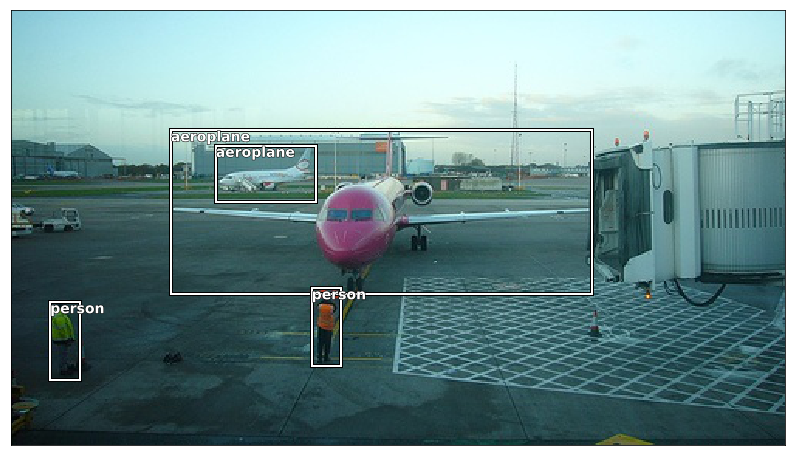

In [99]:
def draw_idx(idx):
    im = open_image(img_path/trn_fns[idx])
    im_anno = trn_annos[idx]
    draw_image(im, im_anno)

draw_idx(32)

## Largest item classifier

In [75]:
def largest_box(annos):
    # anno: array of tuples
    b = sorted(annos, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)  # sorted iterates through array
    if b: 
        return b[0]
    else:
        return b

In [76]:
trn_annos_sorted = {k: largest_box(v) for k,v in trn_annos.items()}

In [77]:
trn_annos_sorted

{12: (array([ 96, 155, 269, 350]), 'car'),
 17: (array([ 77,  89, 335, 402]), 'horse'),
 23: (array([  1,   2, 461, 242]), 'person'),
 26: (array([124,  89, 211, 336]), 'car'),
 32: (array([ 77, 103, 182, 374]), 'aeroplane'),
 33: (array([106,   8, 262, 498]), 'aeroplane'),
 34: (array([166, 115, 399, 359]), 'train'),
 35: (array([ 97, 217, 317, 464]), 'person'),
 36: (array([ 78,  26, 343, 318]), 'dog'),
 42: (array([ 31, 262, 294, 499]), 'train'),
 44: (array([  0,   0, 329, 369]), 'chair'),
 47: (array([  0,  14, 311, 458]), 'car'),
 48: (array([  0,   1, 499, 301]), 'person'),
 61: (array([ 10, 273, 278, 436]), 'boat'),
 64: (array([ 22,   0, 499, 450]), 'bird'),
 66: (array([181, 241, 258, 273]), 'person'),
 73: (array([142, 120, 459, 374]), 'pottedplant'),
 77: (array([  0,   1, 332, 305]), 'cat'),
 78: (array([ 74,  14, 411, 474]), 'dog'),
 83: (array([ 32, 108, 308, 446]), 'car'),
 89: (array([ 50,  21, 290, 316]), 'chair'),
 91: (array([240, 124, 283, 194]), 'car'),
 104: (arr

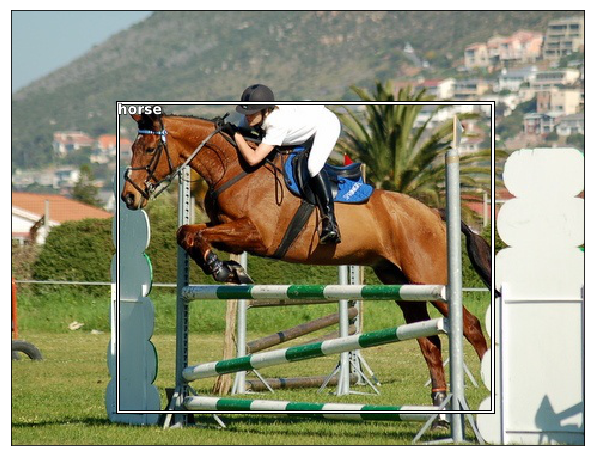

In [86]:
def draw_idx_sorted(idx):
    box,cat = trn_annos_sorted[idx]
    im = open_image(img_path/trn_fns[idx])
    ax = show_image(im, figsize=(16,8))
    b = bb_hw(box)
    draw_rect(ax, b)
    draw_text(ax, b[:2], cat)
    
draw_idx_sorted(17)

## Save as CSV

In [89]:
df = pd.DataFrame({'filename': [trn_fns[o] for o in trn_ids], 'category': [trn_annos_sorted[i][1] for i in trn_ids]}, columns=['filename', 'category'])
df

,filename,category
0,000012.jpg,car
1,000017.jpg,horse
2,000023.jpg,person
3,000026.jpg,car
4,000032.jpg,aeroplane
5,000033.jpg,aeroplane
6,000034.jpg,train
7,000035.jpg,person
8,000036.jpg,dog
9,000042.jpg,train


In [94]:
!ls {PATH}

PASCAL_VOC.zip              pascal_train2012.json
VOCdevkit                   pascal_val2007.json
VOCtrainval_06-Nov-2007.tar pascal_val2012.json
pascal_test2007.json        tmp
pascal_train2007.json


In [14]:
os.makedirs(PATH/'tmp', exist_ok=True)
CSV = PATH/'tmp/largest.csv'

In [96]:
df.to_csv(CSV, index=False)

## Learn largest object

In [12]:
f = resnet34
sz = 224
bs = 64

In [15]:
tfms = tfms_from_model(f,sz,aug_tfms=transforms_side_on,crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, jpegs, CSV, bs=bs, tfms=tfms)

In [16]:
x,y = next(iter(md.trn_ds))

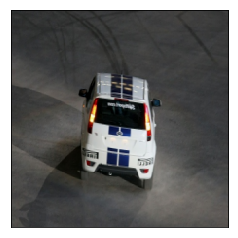

In [17]:
show_image(md.trn_ds.denorm(to_np(x))[0])

In [18]:
learn = ConvLearner.pretrained(f, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [19]:
learn.lr_find()

 91%|█████████ | 29/32 [00:08<00:00,  3.31it/s, loss=10.3]


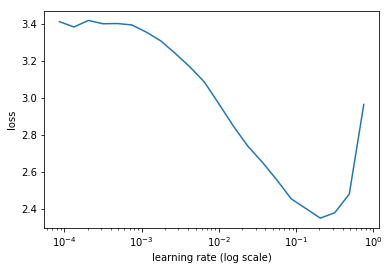

In [20]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [21]:
lr = 2e-2

In [22]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.24314    0.679355   0.806     



[0.6793548445701599, 0.8059999980926513]

In [26]:
lrs = np.array([2e-5, 2e-4, lr])

In [27]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:17<00:03,  1.52it/s, loss=3.67] 

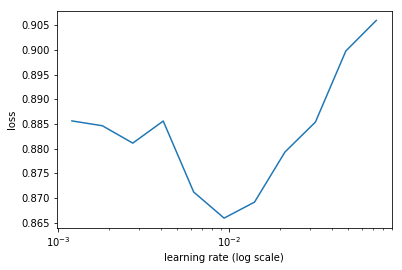

In [29]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [30]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.81257    0.620778   0.818     


[0.6207784740924835, 0.8179999976158142]

In [31]:
learn.unfreeze()

In [32]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.650209   0.639661   0.818     
    1      0.441847   0.590753   0.832                     


[0.5907529969215393, 0.8320000009536743]

In [33]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.371324   0.588689   0.834     
    1      0.267601   0.57447    0.834                     


[0.5744700667858124, 0.8340000009536743]

In [34]:
learn.save('largest_object')

In [35]:
x,y = next(iter(md.val_dl))

In [36]:
pred = predict_batch(learn.model, x)  # torch.Size([64, 20])

In [39]:
probs = F.softmax(pred, -1)

In [43]:
x,preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


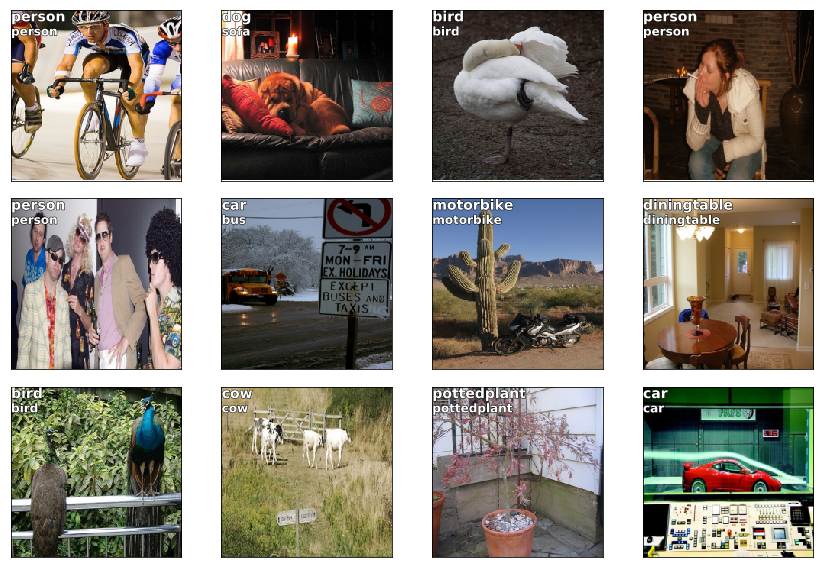

In [51]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_image(ima, ax=ax)
    draw_text(ax, (0,0), b)
    y_act = md.classes[y[i]]
    draw_text(ax, (0,20), y_act, sz=12)
plt.tight_layout()